### Learning Tensorboard Basics

Following tutorial from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/4_Utils/tensorboard_advanced.ipynb

In [1]:
from __future__ import print_function

import tensorflow as tf

#import mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

/Users/Nina/Documents/Streamba/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [10]:
# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1
logs_path = 'logs/tensorboard_basics/'

# Network Parameters
n_hidden_1 = 256 # 1st layer n. of features
n_hidden_2 = 256 # 2nd layer n. of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST classes (0-9 digits)

### Phase 1: assemble your graph

1. Import data (either with tf.data or with placeholders)
2. Define the weights
3. Define the inference model
4. Define loss function
5. Define optimizer

**placeholders**: variable to which data will be assigned later on. Allows for building graphs without having the data.

```placehoder(type, shape, name)```

In [3]:
# tf Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition => 10 classes
y = tf.placeholder(tf.float32, [None, 10], name='LabelData')

#### creating the model (step 3)

try making it as pythonic as possible. Good modularity

Create a basic multilayer perceptron with 2 hidden layers and relu activation funciton.

**tf.summary**: way to condense information that can then be visualised in the Tensorboard. Summaries can be saved to file using **_tf.summary.FileWriter( some-directory, sess.graph)_**

In [4]:
# Store layers weight & bias
weights = {
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1]), name='W1'),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name='W2'),
    'w3': tf.Variable(tf.random_normal([n_hidden_2, n_classes]), name='W3')
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1]), name='b1'),
    'b2': tf.Variable(tf.random_normal([n_hidden_2]), name='b2'),
    'b3': tf.Variable(tf.random_normal([n_classes]), name='b3')
}

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1']) 
    layer_1 = tf.nn.relu(layer_1)
    # Create a summary to visualize the first layer ReLU activation
    tf.summary.histogram("relu1", layer_1) #summary ops
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Create another summary to visualize the second layer ReLU activation
    tf.summary.histogram("relu2", layer_2)
    # Output layer
    out_layer = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    return out_layer



**NAME SHARING**: groups ops into *scopes*. Aids with visualizing in tensorboard

Also follow by defining **loss** and **optimization** functions (steps 4 and 5)

In [5]:
with tf.name_scope('Model'):
    percep = multilayer_perceptron(x, weights, biases)
    
with tf.name_scope('Loss'):
    #create loss function
    #softmax cross entropy
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=percep, labels=y))

with tf.name_scope('Optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    
    # Op to calculate variable gradient
    grads = optimizer.compute_gradients(loss, tf.trainable_variables())
    
    #create optimizer - STOCHASTIC GRADIENT DESCENT
    apply_grads = optimizer.apply_gradients(grads_and_vars=grads)

    
with tf.name_scope('Accuracy'):
    acc = tf.equal(tf.argmax(percep, 1), tf.argmax(y,1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

### Phase 2: execute the computation - which is basically training your model. 

1. Initialize all model variables for the first time.
2. Initialize iterator / feed in the training data.
3. Execute the inference model on the training data, so it calculates for each training input example the output with the current model parameters.
4. Compute the cost
5. Adjust the model parameters to minimize/maximize the cost depending on the model.

In [6]:
grads

[(<tf.Tensor 'Optimizer/gradients/Model/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 256) dtype=float32>,
  <tf.Variable 'W1:0' shape=(784, 256) dtype=float32_ref>),
 (<tf.Tensor 'Optimizer/gradients/Model/MatMul_1_grad/tuple/control_dependency_1:0' shape=(256, 256) dtype=float32>,
  <tf.Variable 'W2:0' shape=(256, 256) dtype=float32_ref>),
 (<tf.Tensor 'Optimizer/gradients/Model/MatMul_2_grad/tuple/control_dependency_1:0' shape=(256, 10) dtype=float32>,
  <tf.Variable 'W3:0' shape=(256, 10) dtype=float32_ref>),
 (<tf.Tensor 'Optimizer/gradients/Model/Add_grad/tuple/control_dependency_1:0' shape=(256,) dtype=float32>,
  <tf.Variable 'b1:0' shape=(256,) dtype=float32_ref>),
 (<tf.Tensor 'Optimizer/gradients/Model/Add_1_grad/tuple/control_dependency_1:0' shape=(256,) dtype=float32>,
  <tf.Variable 'b2:0' shape=(256,) dtype=float32_ref>),
 (<tf.Tensor 'Optimizer/gradients/Model/Add_2_grad/tuple/control_dependency_1:0' shape=(10,) dtype=float32>,
  <tf.Variable 'b3:0' shape=(10,) 

In [7]:
#initialize
init = tf.global_variables_initializer()

#monitor loss and accuracy
tf.summary.scalar('loss', loss)
tf.summary.scalar('acc', acc)

#create summary to visualize weights
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

    
#create summaries to visualize gradients
for grad, var in grads:
    tf.summary.histogram(var.name + '/gradient', grad)

INFO:tensorflow:Summary name W1:0 is illegal; using W1_0 instead.
INFO:tensorflow:Summary name W2:0 is illegal; using W2_0 instead.
INFO:tensorflow:Summary name W3:0 is illegal; using W3_0 instead.
INFO:tensorflow:Summary name b1:0 is illegal; using b1_0 instead.
INFO:tensorflow:Summary name b2:0 is illegal; using b2_0 instead.
INFO:tensorflow:Summary name b3:0 is illegal; using b3_0 instead.
INFO:tensorflow:Summary name W1:0/gradient is illegal; using W1_0/gradient instead.
INFO:tensorflow:Summary name W2:0/gradient is illegal; using W2_0/gradient instead.
INFO:tensorflow:Summary name W3:0/gradient is illegal; using W3_0/gradient instead.
INFO:tensorflow:Summary name b1:0/gradient is illegal; using b1_0/gradient instead.
INFO:tensorflow:Summary name b2:0/gradient is illegal; using b2_0/gradient instead.
INFO:tensorflow:Summary name b3:0/gradient is illegal; using b3_0/gradient instead.


In [8]:
#to simplify and manage all the summaries it is easier to merge all summaries together
summary_op = tf.summary.merge_all()

**Start Training**

**tf.summary.FileWriter**: op that writes summaries to tensorboard

In [14]:
with tf.Session() as sess:
    #run initializer
    #always initialize the vairables first
    sess.run(init)
    
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    #training cycle based on number of epochs
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            _, cost, summary = sess.run([apply_grads, loss, summary_op], 
                                        feed_dict={x: batch_xs, y: batch_ys})
            
            #save logs to writer with every iteration
            
            #summary: summary logs
            #global_step: number of batches seen by the graph so far
            writer.add_summary(summary, epoch*total_batch+i)
            
            #update cost
            avg_cost += cost/ total_batch
        
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
            
    
    # Calculate accuracy
    print("Accuracy:", acc.eval({x: mnist.test.images, y: mnist.test.labels}))

Epoch: 0001 cost= 54.453609285
Epoch: 0002 cost= 13.899013306
Epoch: 0003 cost= 9.064845852
Epoch: 0004 cost= 6.025743988
Epoch: 0005 cost= 4.808659604
Epoch: 0006 cost= 3.474402097
Epoch: 0007 cost= 2.799420129
Epoch: 0008 cost= 2.362041475
Epoch: 0009 cost= 1.876676828
Epoch: 0010 cost= 1.567828653
Epoch: 0011 cost= 1.342660358
Epoch: 0012 cost= 1.082643695
Epoch: 0013 cost= 0.901039837
Epoch: 0014 cost= 0.804671399
Epoch: 0015 cost= 0.644176857
Epoch: 0016 cost= 0.543919574
Epoch: 0017 cost= 0.472080599
Epoch: 0018 cost= 0.363465421
Epoch: 0019 cost= 0.316704413
Epoch: 0020 cost= 0.261189742
Epoch: 0021 cost= 0.234982749
Epoch: 0022 cost= 0.190555038
Epoch: 0023 cost= 0.149279013
Epoch: 0024 cost= 0.138384148
Epoch: 0025 cost= 0.101285983
Accuracy: 0.9376


**Different histograms**

Can show offset or overlay the different values for each individual step

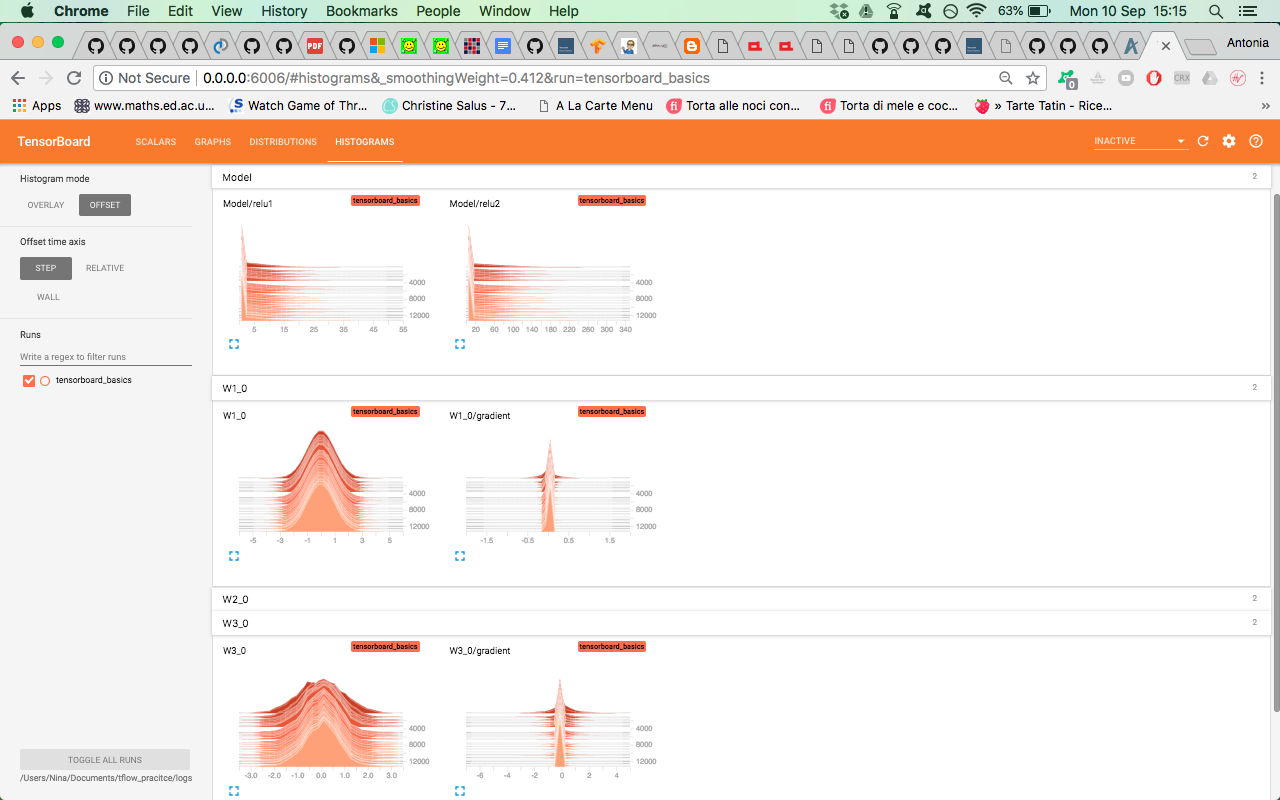

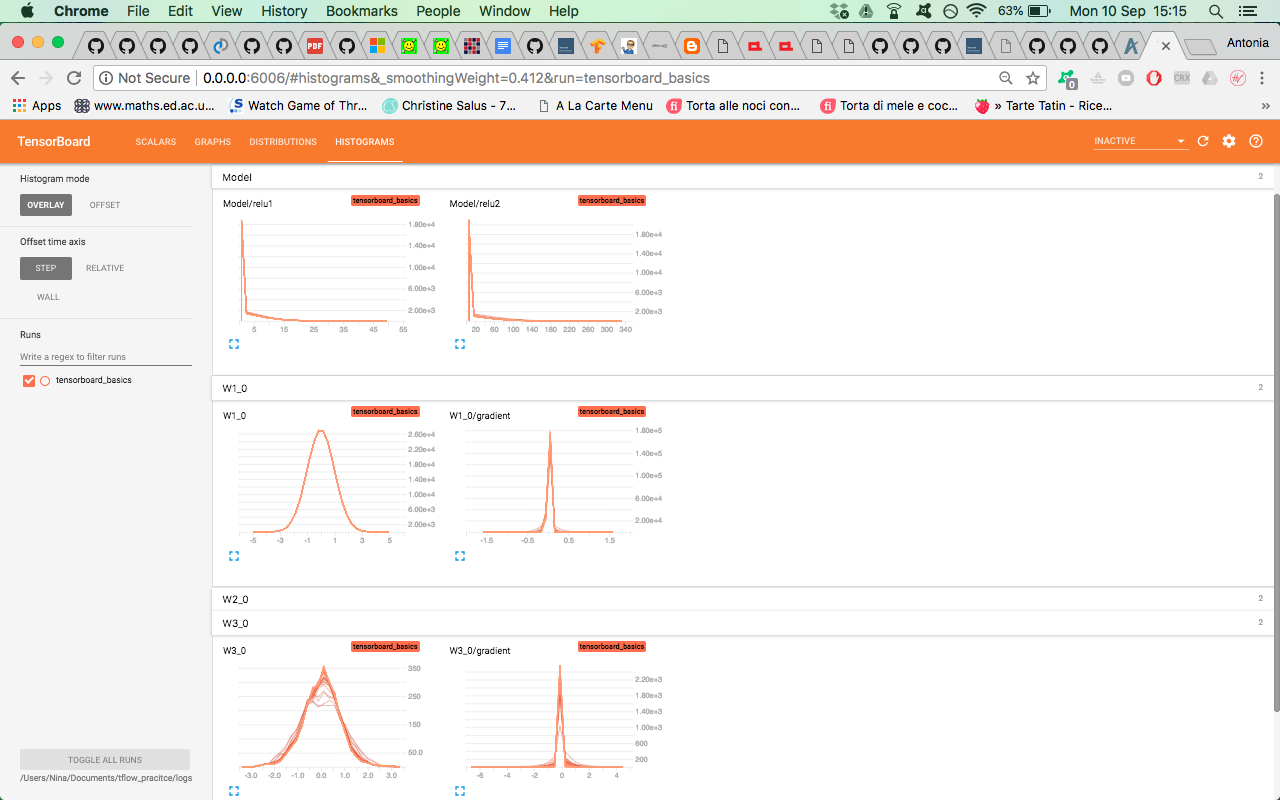

**Accuracy and Loss**

Shows accuracy increase and loss decrease with each step

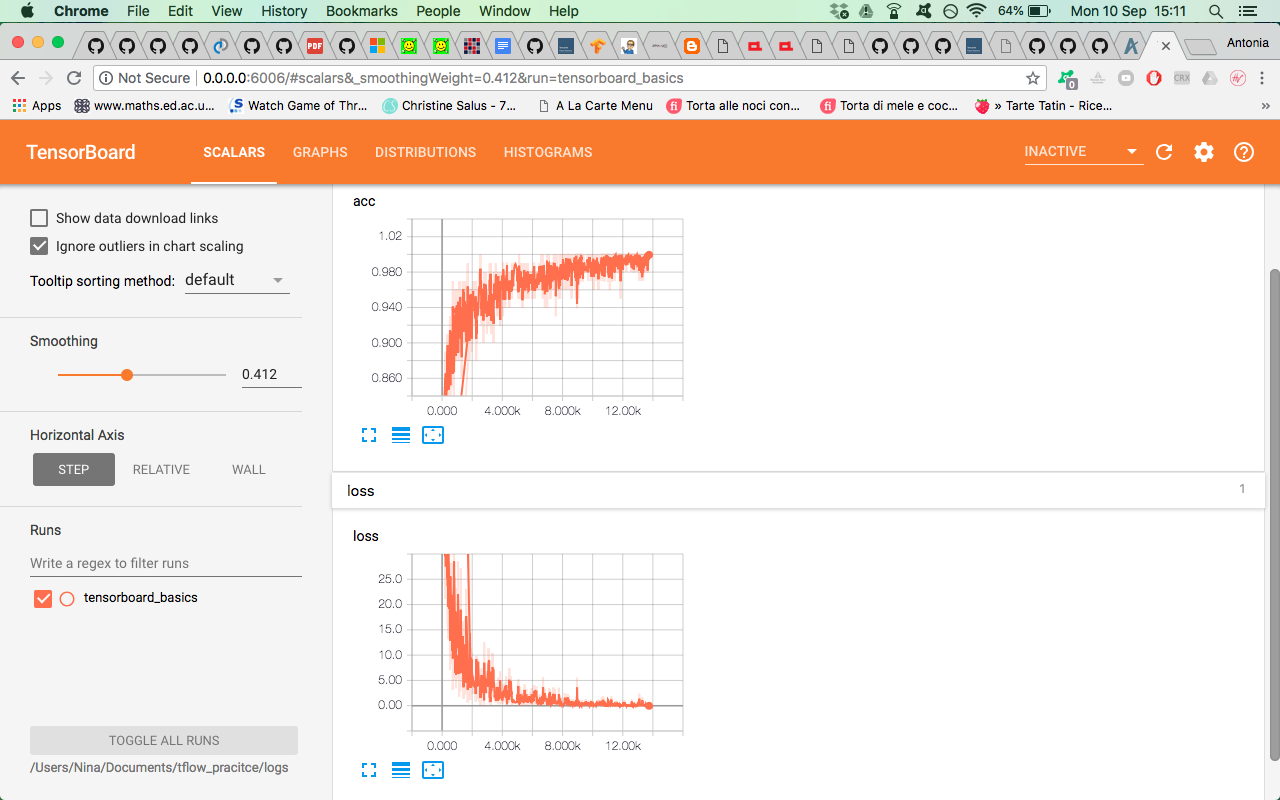

**Showing the model**
Shows the different layers. Easy to see where summaries are displayed for the model. The model is expandable and cascadable. Easy to check for nodes, inputs and outputs at each situation

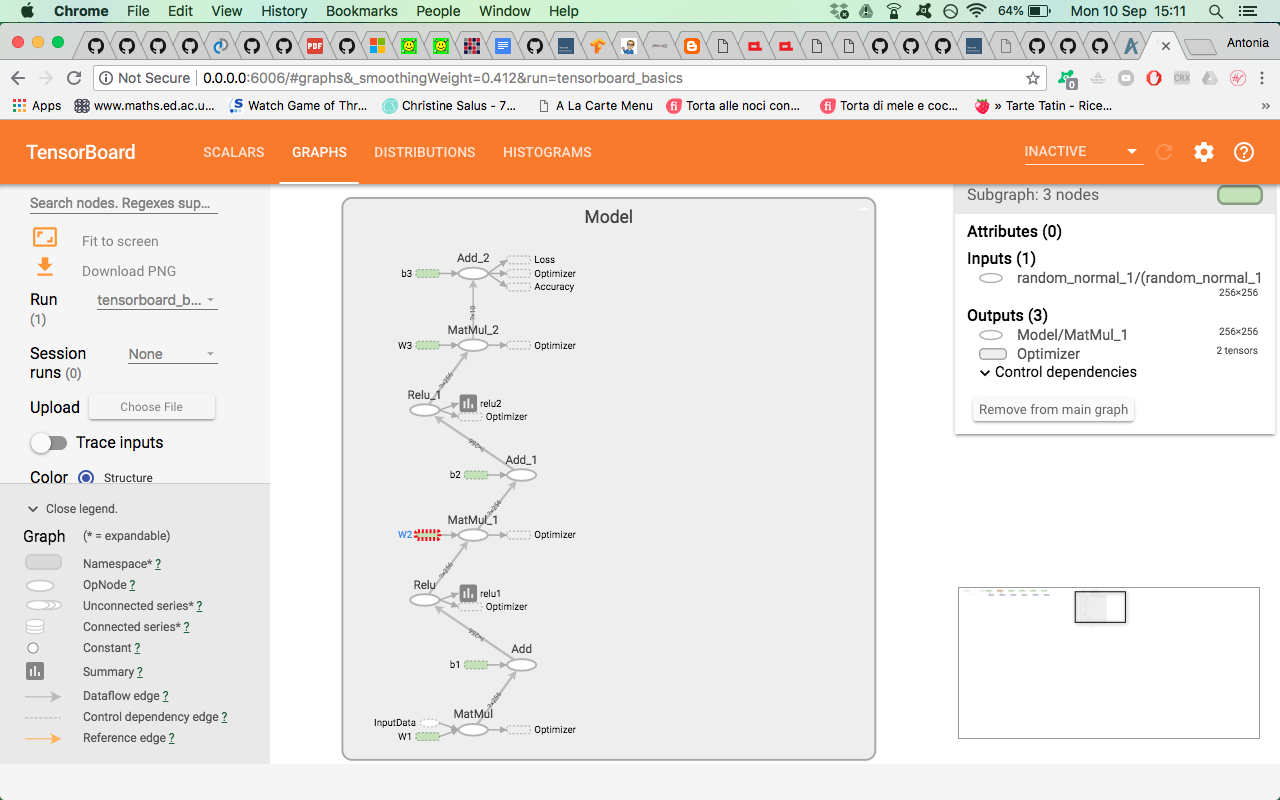